In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 2.5
duration = 0.2
t_end = t_start + duration
shape = (180, 240)
dataset = "data/slider_far/"

In [4]:
events_raw = np.loadtxt(path + dataset + "events.txt", max_rows=10000000)

In [5]:
sub_factor=2

In [6]:
events_t = flt.filter_time(events_raw, t_start, t_end)

In [7]:
patch_center = (80, 70)
patch_size = 50
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events_p = flt.filter_patch(events_t, patch_center, patch_size)

In [8]:
events_conv, new_shape = flt.filter_conv(events_p, shape, factor=sub_factor)
shape = new_shape
print(shape)

(90, 90)


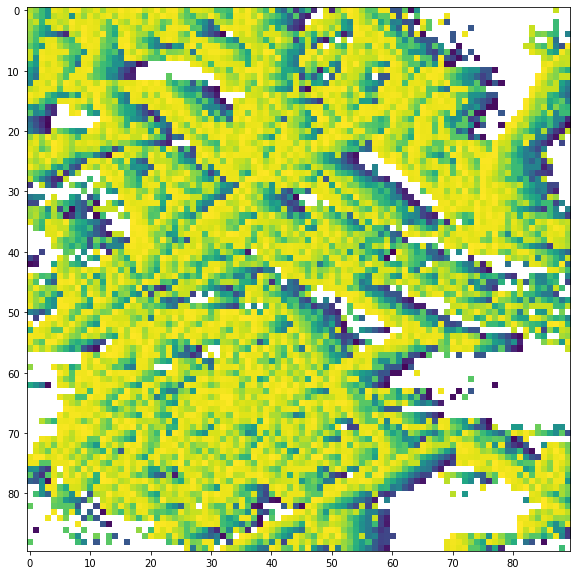

In [9]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_conv, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

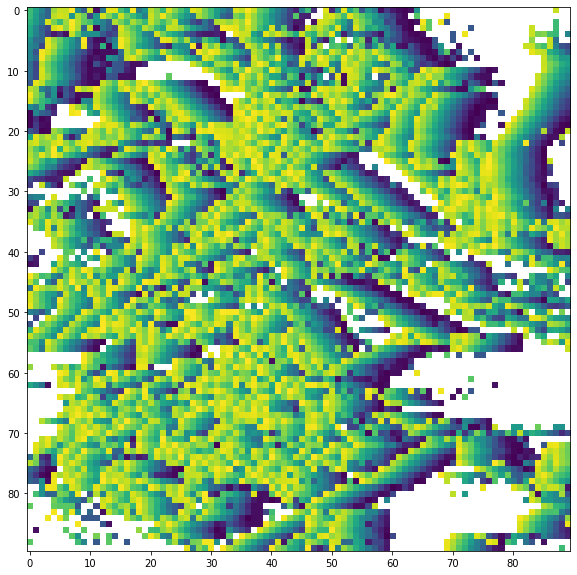

In [10]:
events = flt.filter_refract(events_conv, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [11]:
calib = np.loadtxt(path + dataset + "calib.txt") / sub_factor

In [12]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")

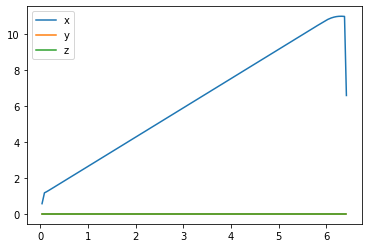

In [13]:
k = np.ones(10)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [14]:
def measure_td(events, shape, dist=1, start_delay=0.1):
    last_time = np.full(shape, -1.0)
    td_predictions = {}
    predictions = {}
    event_sign = np.full(shape, -1)

    U = np.zeros(shape)
    V = np.zeros(shape)

    start_time = events[0, 0]

    for e in tqdm(events):
        x = int(e[1])
        y = int(e[2])

        last_sign = event_sign[y, x]
        last_time[y, x] = e[0]
        event_sign[y, x] = e[3]

        if e[0] < start_time + start_delay:
            continue

        u_td = (e[0] - last_time[y - dist, x]
                if y - dist >= 0 and last_time[y - dist, x] != -1.0 and event_sign[y - dist, x] == e[3]
                else -1.0)
        d_td = (e[0] - last_time[y + dist, x]
                if y + dist < shape[0] and last_time[y + dist, x] != -1.0 and event_sign[y + dist, x] == e[3]
                else -1.0)
        r_td = (e[0] - last_time[y, x + dist]
                if x + dist < shape[1] and last_time[y, x + dist] != -1.0 and event_sign[y, x + dist] == e[3]
                else -1.0)
        l_td = (e[0] - last_time[y, x - dist]
                if x - dist >= 0 and last_time[y, x - dist] != -1.0 and event_sign[y, x - dist] == e[3]
                else -1.0)

        if u_td <= 0.0:
            if d_td <= 0.0:
                v_td = 0.0
                continue
            else:
                v_td = d_td
        else:
            if d_td > 0:
                #v_td = d_td if d_td >= u_td else -u_td
                v_td = 0.0
                continue
            else:
                v_td = -u_td

        if r_td <= 0.0:
            if l_td <= 0.0:
                h_td = 0.0
                continue
            else:
                h_td = l_td
        else:
            if l_td > 0:
                #h_td = l_td if l_td >= r_td else -r_td
                h_td = 0.0
                continue
            else:
                h_td = -r_td
                
        m = np.sqrt((h_td/ dist)**2 + (v_td/dist)**2)
        
#         if m < 0.005:
#             continue
                
        U[y, x] = h_td / dist #if h_td != 0.0 else 0.0
        V[y, x] = v_td / dist # if v_td != 0.0 else 0.0
        
    return U, V

In [15]:
# U, V = measure_td(events, shape, dist=2)
# U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=2, px_range_pred=7, std_thr=1.1, mean_thr=1000.03, start_delay=0.03, final_delay=0.05)
U, V = td2d.measure_td_raw(events, shape, dist=1)

100%|█████████████████████████████████████████████████████████████████████████| 14876/14876 [00:00<00:00, 42888.28it/s]


In [16]:
m = np.sqrt(U**2 + V**2)

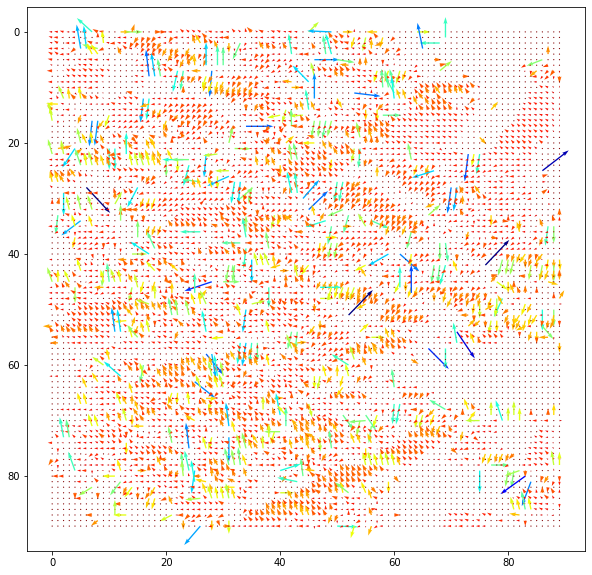

In [17]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

-46.72569570530789


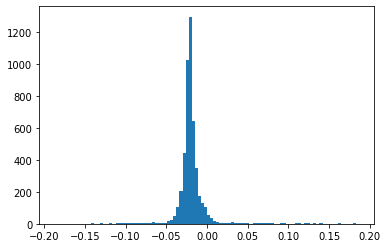

In [18]:
m_ma = np.ma.masked_where(np.isclose(U, 0.0), U)
plt.hist(m_ma.compressed(), 100);
print(1 / np.ma.median(m_ma))

In [19]:
# time_d = td2d.TimeDifference2d(shape, events, poses, calib[0])
# final_td, td_predictions, U, V, diff_list = time_d.compute_time_difference(dist = 2, px_range_pred=9, delay=0.15, avg_n=5, std_mul=0.005, debug=True, start_delay=0.05)
# m = np.sqrt(U**2 + V**2)

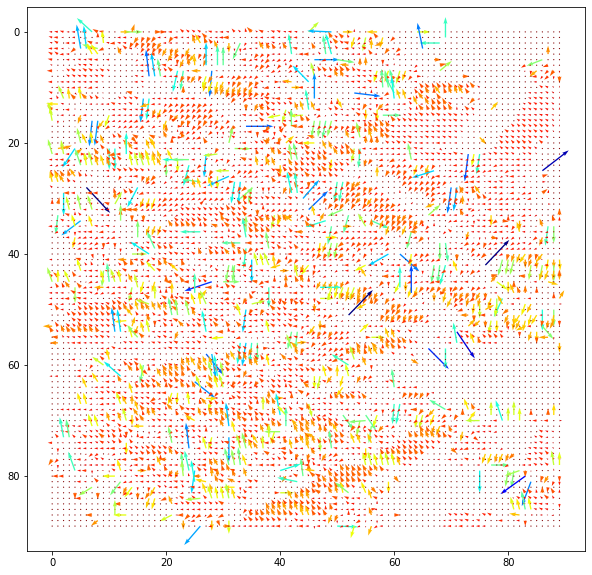

In [20]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

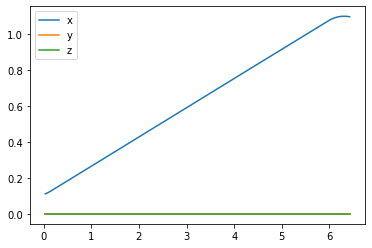

In [21]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
# k = np.ones(10)
# poses[:,1] = np.convolve(poses[:,1], k, mode="same")
# poses[:,2] = np.convolve(poses[:,2], k, mode="same")
# poses[:,3] = np.convolve(poses[:,3], k, mode="same")
# poses[:,4] = np.convolve(poses[:,4], k, mode="same")
# poses[:,5] = np.convolve(poses[:,5], k, mode="same")
# poses[:,6] = np.convolve(poses[:,6], k, mode="same")
# poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [22]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[0. 0. 0.]


In [23]:
def get_angular_flow(w, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [(xi * yi) / f, -(f + xi ** 2 / f), yi],
                [f + yi ** 2 / f, -xi * yi / f, -xi]
            ])
            r = m @ w
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [24]:
ang_U, ang_V = get_angular_flow(vel, calib[0], shape)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


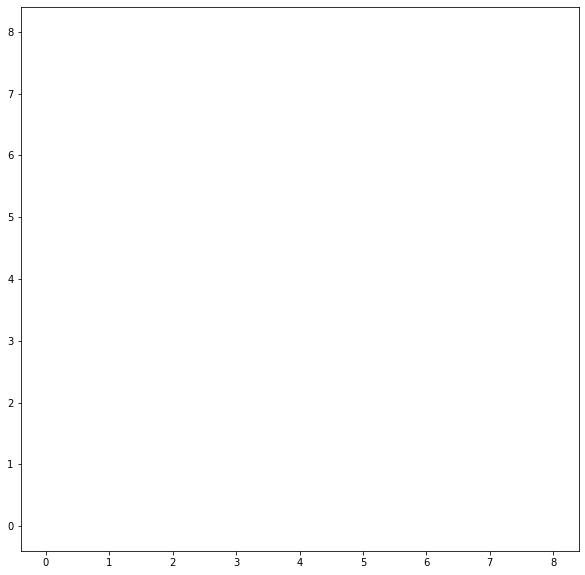

In [25]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [26]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = (t2 - t1) / (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

[0.51026953 0.         0.        ]
[0.51183203 0.         0.        ]
[0.16362094 0.         0.        ]
0.0095495109999999


In [27]:
def get_translational_flow(t, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [-f, 0, xi],
                [0, -f, yi]
            ])
            r = m @ t
            U_flow[y, x] = r[0] if r[0] != 0.0 else 0.0
            V_flow[y, x] = r[1] if r[1] != 0.0 else 0.0
            
    return U_flow, V_flow

In [28]:
t_U, t_V = get_translational_flow(t_vel, calib[0], shape)

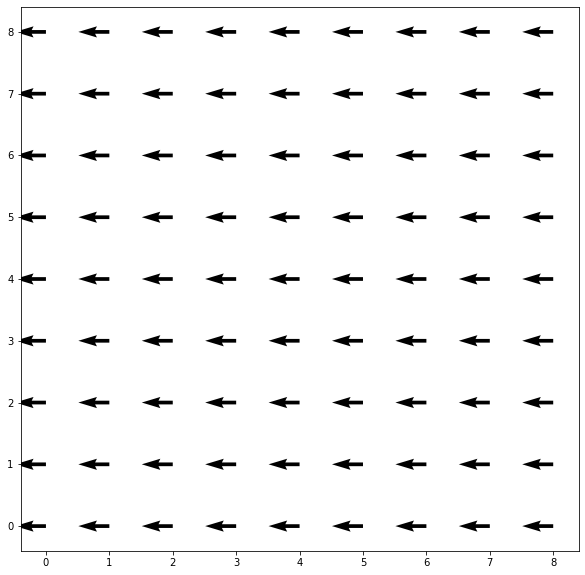

In [29]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

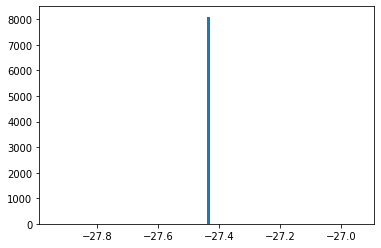

In [30]:
plt.hist(t_U.flatten(), 100);

In [49]:
t_U

array([[-27.4408245, -27.4408245, -27.4408245, ..., -27.4408245,
        -27.4408245, -27.4408245],
       [-27.4408245, -27.4408245, -27.4408245, ..., -27.4408245,
        -27.4408245, -27.4408245],
       [-27.4408245, -27.4408245, -27.4408245, ..., -27.4408245,
        -27.4408245, -27.4408245],
       ...,
       [-27.4408245, -27.4408245, -27.4408245, ..., -27.4408245,
        -27.4408245, -27.4408245],
       [-27.4408245, -27.4408245, -27.4408245, ..., -27.4408245,
        -27.4408245, -27.4408245],
       [-27.4408245, -27.4408245, -27.4408245, ..., -27.4408245,
        -27.4408245, -27.4408245]])

In [31]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

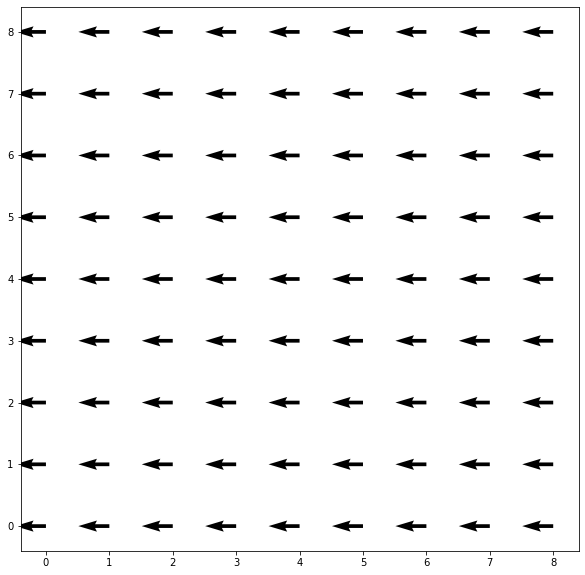

In [32]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [33]:
# test_u = np.zeros(shape)
# test_v = np.zeros(shape)
# test = np.zeros(shape)
# for x in range(U.shape[1]):
#     for y in range(U.shape[0]):
        
#         m = np.sqrt(np.square(U[y, x]) + np.square(V[y, x])) ** 2
#         l = (ang_U[y, x]* U[y, x] + ang_V[y, x] * V[y, x]) / m

#         if m == 0.0:
#             continue
        
#         ang_p_u = U[y, x] * l
#         ang_p_v = V[y, x] * l
        
#         U_t = U[y, x] - ang_p_u
#         V_t = V[y, x] - ang_p_v
        
#         test_u[y, x] = U_t
#         test_v[y, x] = V_t
        
#         n = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) ** 2
#         p = (U_t*t_U[y, x] + V_t*t_V[y, x]) / n
        
#         u = t_U[y, x] * p
#         v = t_V[y, x] * p
        
#         test_u[y, x] = u
#         test_v[y, x] = v
        
#         a = t_U[y, x] * u if u != 0.0 else 0.0
#         b = t_V[y, x] * v if v != 0.0 else 0.0
        
#         d = 1 / (a + b)
        
#         d = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) / np.sqrt(u**2 + v**2)
        
#         d = 1 / (t_U[y, x] / n * U_t + t_V[y, x] / n * V_t)

#         test[y, x] = d

In [34]:
# test_u = np.zeros(shape)
# test_v = np.zeros(shape)
# test = np.zeros(shape)
# for x in range(U.shape[1]):
#     for y in range(U.shape[0]):
        
#         tdu = U[y, x]
#         tdv = V[y, x]
        
#         if tdu == 0.0 and tdv == 0.0:
#             continue
        
#         #find the normal flow
#         tdn = np.sqrt(tdu**2+tdv**2)
#         un = 1 / tdn
        
#         u = (tdu / tdn) * un
#         v = (tdv / tdn) * un
        
#         tu = t_U[y, x]
#         tv = t_V[y, x]
        
#         #find optical flow with projection 
        
#         z_inv = un / (tu*(u / un) + tv*(v / un))
        
#         test_u[y, x] = tu * z_inv
#         test_v[y, x] = tv * z_inv
        
#         if 1 / z_inv >= 2.0:
#             continue
        
#         test[y, x] = 1 / z_inv

In [35]:
test, test_u, test_v = td2d.extract_depth(shape, U, V, t_U, t_V)

0.6172974579966388


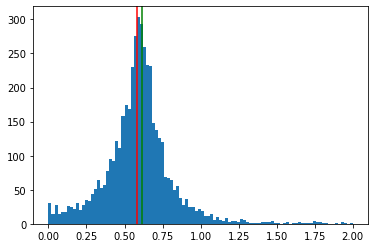

In [36]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100, range=(0, 2));
plt.axvline(x=0.581, c="red")
plt.axvline(x=np.ma.mean(test_m), c="green")
print(np.ma.mean(test_m))

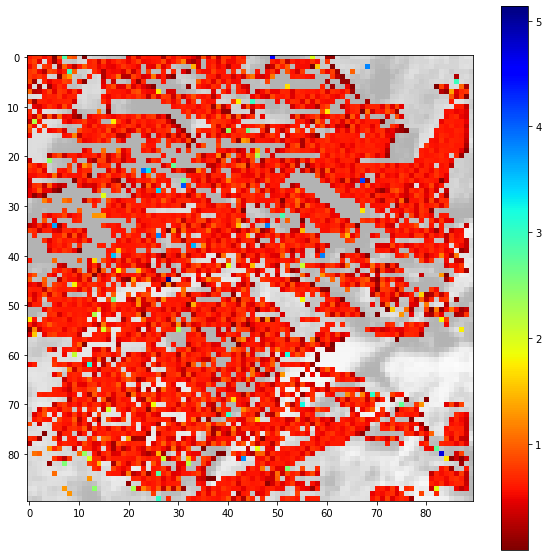

In [37]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + dataset + "images/frame_00000057.png")
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

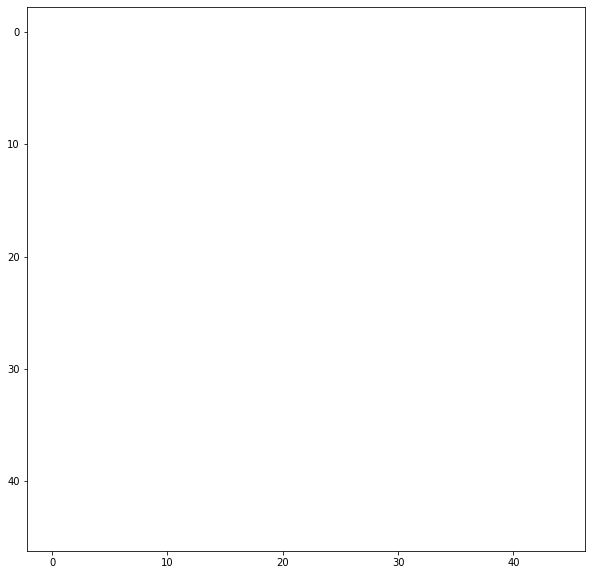

In [38]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(np.square(test_v) + np.square(test_u))
a = 2
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

--


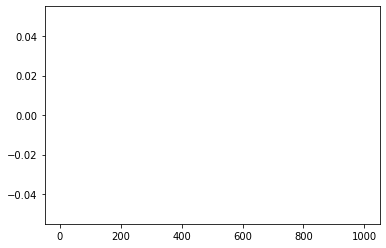

In [39]:
test_m = np.ma.masked_where(np.logical_or(m == 0.0, m > 1000), m)
plt.hist(test_m.compressed(), 100, range=(0, 1000));
print(np.ma.median(test_m))

In [40]:
1 / np.ma.mean(test_m)

masked

In [41]:
# %matplotlib qt
# vis.visualize3d(test_m)

In [42]:
d = test_m

In [43]:
gt_d = 0.584

In [44]:
mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

nan


c:\users\schiavaz\lava-nc\venv\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\schiavaz\lava-nc\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)

nan


In [46]:
np.ma.median(d)

masked

In [47]:
d

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float64)

In [48]:
(0.16 / 0.584) * 335.41

91.89315068493153